In [1]:
# Import all required libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from imblearn.over_sampling import SMOTE

In [2]:
# Load dataset
df = pd.read_csv("data (1).csv")

In [3]:
# View Dataset
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


#### Basic insights

In [4]:
# Dataset Shape
print("Shape:", df.shape)

Shape: (944, 10)


In [5]:
# Columns
print("\nColumns:", df.columns.tolist())


Columns: ['footfall', 'tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature', 'fail']


In [6]:
# Datatype of columns
print("\nDtypes:\n", df.dtypes)


Dtypes:
 footfall       int64
tempMode       int64
AQ             int64
USS            int64
CS             int64
VOC            int64
RP             int64
IP             int64
Temperature    int64
fail           int64
dtype: object


In [7]:
# Missing Values in data rows
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64


In [8]:
# Duplicate Values in data rows
print("\nDuplicates:", df.duplicated().sum())


Duplicates: 1


In [9]:
# Target Value distribution
print("\nTarget (fail) distribution:\n", df['fail'].value_counts())


Target (fail) distribution:
 fail
0    551
1    393
Name: count, dtype: int64


In [10]:
print("\nSummary statistics:\n", df.describe().T)


Summary statistics:
              count        mean          std   min   25%   50%    75%     max
footfall     944.0  306.381356  1082.606745   0.0   1.0  22.0  110.0  7300.0
tempMode     944.0    3.727754     2.677235   0.0   1.0   3.0    7.0     7.0
AQ           944.0    4.325212     1.438436   1.0   3.0   4.0    6.0     7.0
USS          944.0    2.939619     1.383725   1.0   2.0   3.0    4.0     7.0
CS           944.0    5.394068     1.269349   1.0   5.0   6.0    6.0     7.0
VOC          944.0    2.842161     2.273337   0.0   1.0   2.0    5.0     6.0
RP           944.0   47.043432    16.423130  19.0  34.0  44.0   58.0    91.0
IP           944.0    4.565678     1.599287   1.0   3.0   4.0    6.0     7.0
Temperature  944.0   16.331568     5.974781   1.0  14.0  17.0   21.0    24.0
fail         944.0    0.416314     0.493208   0.0   0.0   0.0    1.0     1.0


### Data processing

In [11]:
# Remove duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

In [12]:
# Create a log-transformed footfall feature to reduce skew for EDA / models
df['log_footfall'] = np.log1p(df['footfall'])

In [13]:
# Create an interaction feature: CS * RP (current * rotational position)
df['CS_RP'] = df['CS'] * df['RP']

In [14]:
# VOC binary flag
df['VOC_nonzero'] = (df['VOC'] > 0).astype(int)

### Data Visualisation - EDA

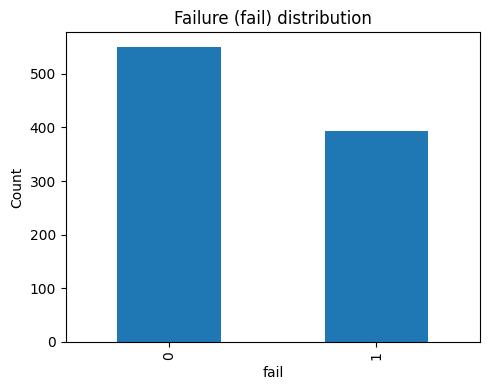

In [15]:
# EDA Graph 1: Target distribution
plt.figure(figsize=(5,4))
df['fail'].value_counts().plot(kind='bar')
plt.title("Failure (fail) distribution")
plt.xlabel("fail")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

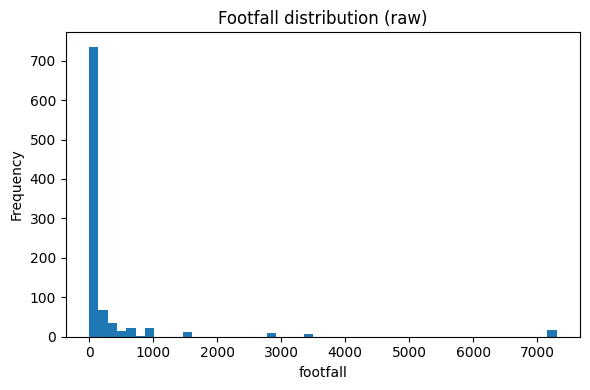

In [16]:
# EDA Graph 2: Histogram of footfall (raw)
plt.figure(figsize=(6,4))
plt.hist(df['footfall'], bins=50)
plt.title("Footfall distribution (raw)")
plt.xlabel("footfall")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

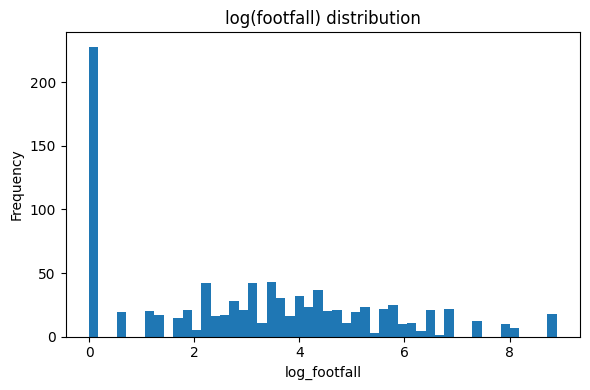

In [17]:
# EDA Graph 3: Histogram of log(footfall)
plt.figure(figsize=(6,4))
plt.hist(df['log_footfall'], bins=50)
plt.title("log(footfall) distribution")
plt.xlabel("log_footfall")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

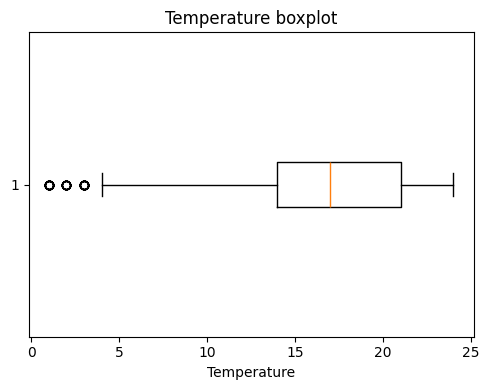

In [18]:
# EDA Graph 4: Boxplot - Temperature
plt.figure(figsize=(5,4))
plt.boxplot(df['Temperature'].dropna(), vert=False)
plt.title("Temperature boxplot")
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()

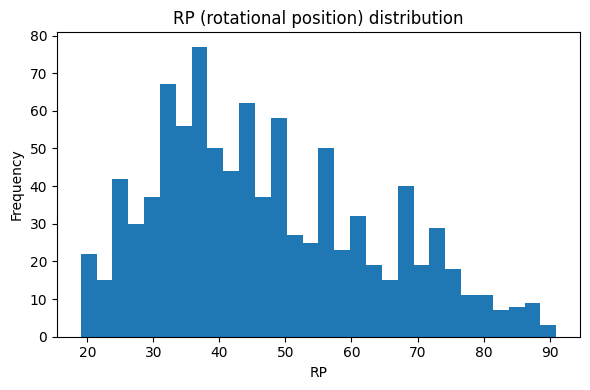

In [19]:
# EDA Graph 5: Histogram - RP (rotational position)
plt.figure(figsize=(6,4))
plt.hist(df['RP'], bins=30)
plt.title("RP (rotational position) distribution")
plt.xlabel("RP")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

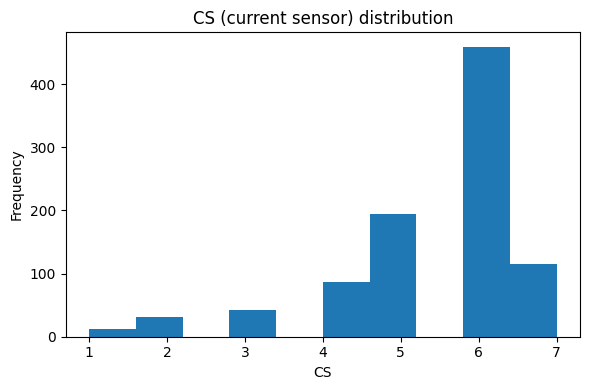

In [20]:
# EDA Graph 6: Histogram - CS (current sensor)
plt.figure(figsize=(6,4))
plt.hist(df['CS'], bins=10)
plt.title("CS (current sensor) distribution")
plt.xlabel("CS")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

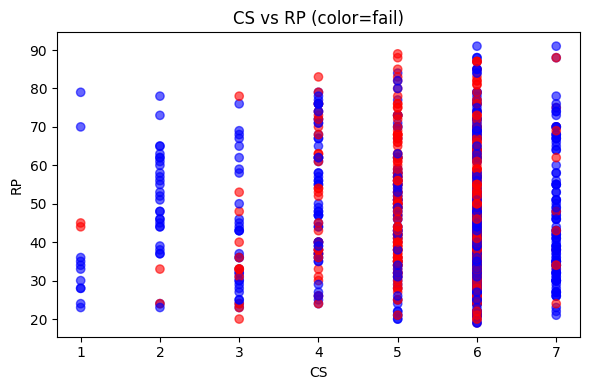

In [21]:
# EDA Graph 7: Scatter - CS vs RP colored by fail
plt.figure(figsize=(6,4))
colors = df['fail'].map({0: 'blue', 1: 'red'})
plt.scatter(df['CS'], df['RP'], c=colors, alpha=0.6)
plt.title("CS vs RP (color=fail)")
plt.xlabel("CS")
plt.ylabel("RP")
plt.tight_layout()
plt.show()

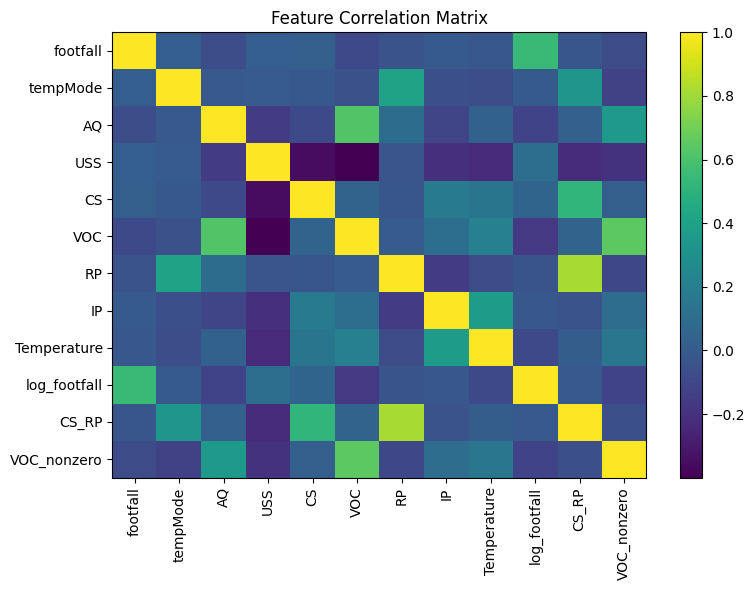

In [22]:
# EDA Graph 8: Correlation heatmap
plt.figure(figsize=(8,6))
corr = df.drop(columns=['fail']).corr()
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### Pre-processing and Feature engineering (for modeling)

In [23]:
# Choose features for modeling
feature_list = [
    'footfall', 'log_footfall', 'tempMode', 'AQ', 'USS',
    'CS', 'VOC', 'RP', 'IP', 'Temperature', 'CS_RP', 'VOC_nonzero']

In [24]:
# Prepare X and y
X = df[feature_list].copy()
y = df['fail'].copy()

In [25]:
# Train-test split with stratification to keep class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [26]:
# Apply SMOTE on training set to handle imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [27]:
# Standard scaling for models requiring scaling (SVM, LogisticRegression)
scaler = StandardScaler()
scaler.fit(X_train_res)
X_train_res_scaled = scaler.transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [28]:
# Convert arrays back to DataFrames for convenience
X_train_res = pd.DataFrame(X_train_res, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
X_train_res_scaled = pd.DataFrame(X_train_res_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

### Model Building and Model Evaluation

* Model 1

In [29]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [30]:
# Train Model using training data
rf_model.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [31]:
# Test Model using test data
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

In [54]:
# Model Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest")
print("Accuracy:", accuracy_rf*100)
print("Precision:", precision_rf*100)
print("Recall:", recall_rf*100)
print("F1-score:", f1_rf*100)
print("ROC-AUC:", roc_auc_rf*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

Random Forest
Accuracy: 91.005291005291
Precision: 86.90476190476191
Recall: 92.40506329113924
F1-score: 89.57055214723927
ROC-AUC: 97.42232451093211

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       110
           1       0.87      0.92      0.90        79

    accuracy                           0.91       189
   macro avg       0.91      0.91      0.91       189
weighted avg       0.91      0.91      0.91       189



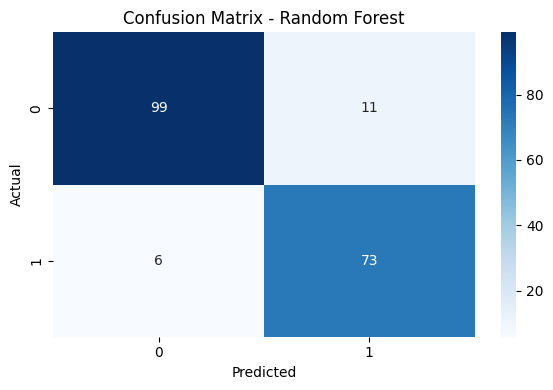

In [33]:
# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

* Model 2

In [34]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

In [35]:
# Train Model using training data
gb_model.fit(X_train_res, y_train_res)

GradientBoostingClassifier(random_state=42)

In [36]:
# Test Model using test data
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

In [55]:
# Model Evaluation
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, zero_division=0)
recall_gb = recall_score(y_test, y_pred_gb, zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, zero_division=0)
roc_auc_gb = roc_auc_score(y_test, y_proba_gb)
cm_gb = confusion_matrix(y_test, y_pred_gb)

print("Gradient Boosting")
print("Accuracy:", accuracy_gb*100)
print("Precision:", precision_gb*100)
print("Recall:", recall_gb*100)
print("F1-score:", f1_gb*100)
print("ROC-AUC:", roc_auc_gb*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb, zero_division=0))

Gradient Boosting
Accuracy: 91.53439153439153
Precision: 88.88888888888889
Recall: 91.13924050632912
F1-score: 90.0
ROC-AUC: 96.31760644418873

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       110
           1       0.89      0.91      0.90        79

    accuracy                           0.92       189
   macro avg       0.91      0.91      0.91       189
weighted avg       0.92      0.92      0.92       189



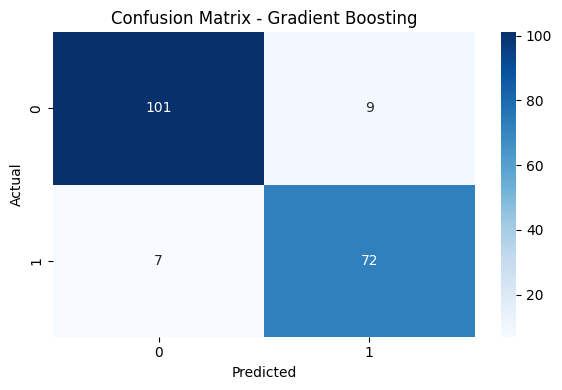

In [38]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

* Model 3

In [39]:
# Support Vector Machine (SVC)
svc_model = SVC(probability=True, random_state=42)

In [40]:
# Train Model using training data
svc_model.fit(X_train_res_scaled, y_train_res)

SVC(probability=True, random_state=42)

In [41]:
# Test Model using test data
y_pred_svc = svc_model.predict(X_test_scaled)
y_proba_svc = svc_model.predict_proba(X_test_scaled)[:, 1]

In [56]:
# Model Evaluation
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc, zero_division=0)
recall_svc = recall_score(y_test, y_pred_svc, zero_division=0)
f1_svc = f1_score(y_test, y_pred_svc, zero_division=0)
roc_auc_svc = roc_auc_score(y_test, y_proba_svc)
cm_svc = confusion_matrix(y_test, y_pred_svc)

print("SVM ")
print("Accuracy:", accuracy_svc*100)
print("Precision:", precision_svc*100)
print("Recall:", recall_svc*100)
print("F1-score:", f1_svc*100)
print("ROC-AUC:", roc_auc_svc*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svc, zero_division=0))

SVM 
Accuracy: 92.5925925925926
Precision: 90.12345679012346
Recall: 92.40506329113924
F1-score: 91.25
ROC-AUC: 97.37629459148447

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94       110
           1       0.90      0.92      0.91        79

    accuracy                           0.93       189
   macro avg       0.92      0.93      0.92       189
weighted avg       0.93      0.93      0.93       189



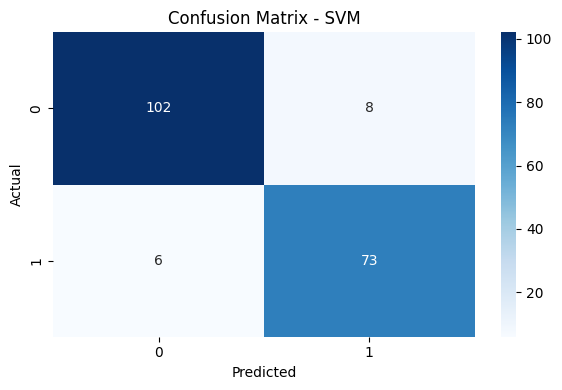

In [43]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

* Model 4

In [44]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

In [45]:
# Train Model using training data
lr_model.fit(X_train_res_scaled, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [46]:
# Test Model using test data
y_pred_lr = lr_model.predict(X_test_scaled)
y_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

In [57]:
# Model Evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("Logistic Regression")
print("Accuracy:", accuracy_lr*100)
print("Precision:", precision_lr*100)
print("Recall:", recall_lr*100)
print("F1-score:", f1_lr*100)
print("ROC-AUC:", roc_auc_lr*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, zero_division=0))

Logistic Regression
Accuracy: 89.94708994708994
Precision: 85.71428571428571
Recall: 91.13924050632912
F1-score: 88.34355828220859
ROC-AUC: 96.3866513233602

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       110
           1       0.86      0.91      0.88        79

    accuracy                           0.90       189
   macro avg       0.90      0.90      0.90       189
weighted avg       0.90      0.90      0.90       189



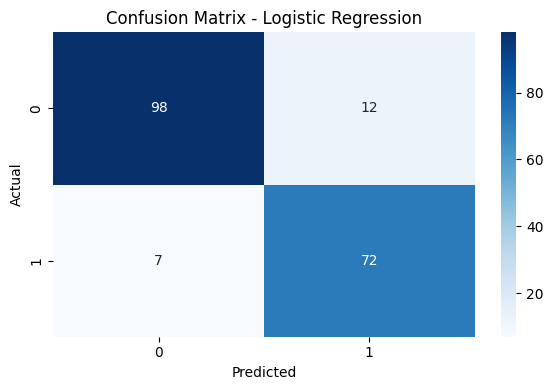

In [48]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### Model Comparision

In [49]:
# Compare all models
metrics_dict = {
    "RandomForest": {
        "Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf,
        "F1": f1_rf, "ROC_AUC": roc_auc_rf
    },
    "GradientBoosting": {
        "Accuracy": accuracy_gb, "Precision": precision_gb, "Recall": recall_gb,
        "F1": f1_gb, "ROC_AUC": roc_auc_gb
    },
    "SVM": {
        "Accuracy": accuracy_svc, "Precision": precision_svc, "Recall": recall_svc,
        "F1": f1_svc, "ROC_AUC": roc_auc_svc
    },
    "LogisticRegression": {
        "Accuracy": accuracy_lr, "Precision": precision_lr, "Recall": recall_lr,
        "F1": f1_lr, "ROC_AUC": roc_auc_lr
    }
}
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
print("\nModel comparison:\n", metrics_df.sort_values(by='F1', ascending=False))


Model comparison:
                     Accuracy  Precision    Recall        F1   ROC_AUC
SVM                 0.925926   0.901235  0.924051  0.912500  0.973763
GradientBoosting    0.915344   0.888889  0.911392  0.900000  0.963176
RandomForest        0.910053   0.869048  0.924051  0.895706  0.974223
LogisticRegression  0.899471   0.857143  0.911392  0.883436  0.963867


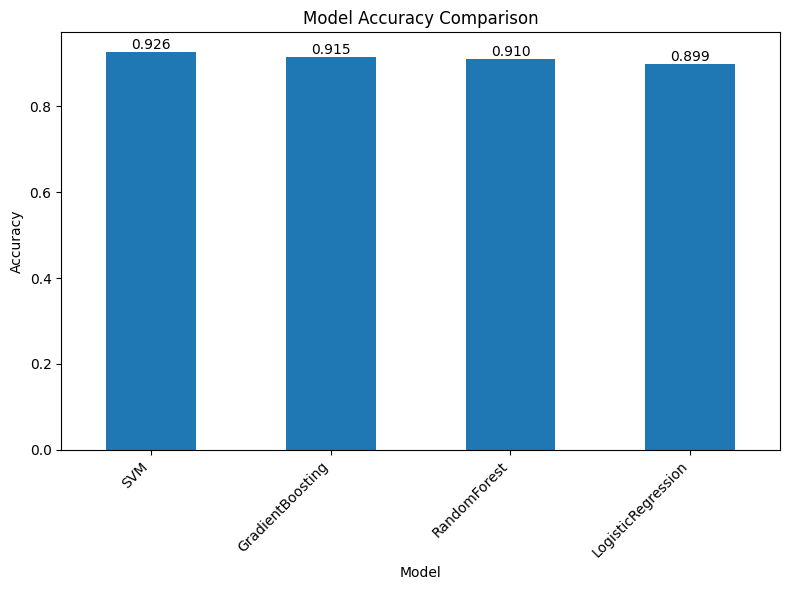

In [52]:
# Bar plot of accuracy for each model
plt.figure(figsize=(8, 6))
ax = metrics_df['Accuracy'].sort_values(ascending=False).plot(kind='bar')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

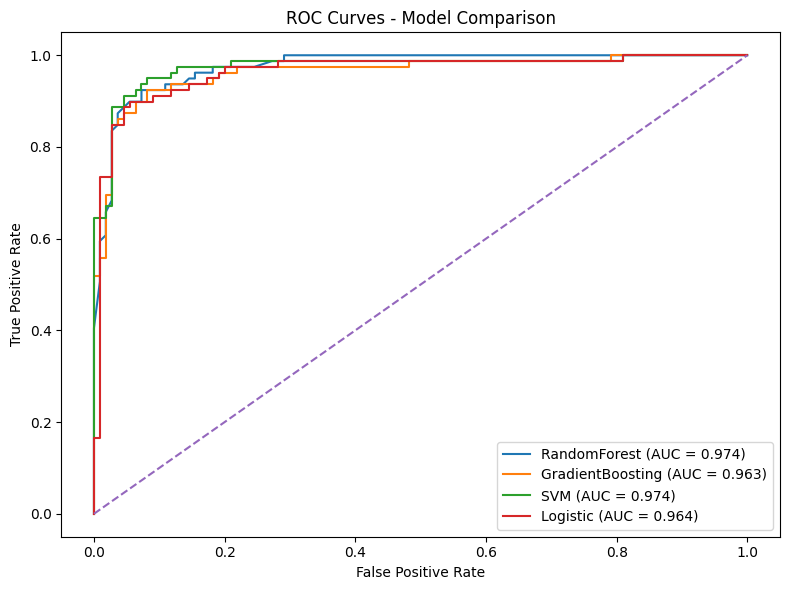

In [50]:
# ROC curves for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_val_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
roc_auc_val_gb = auc(fpr_gb, tpr_gb)

fpr_svc, tpr_svc, _ = roc_curve(y_test, y_proba_svc)
roc_auc_val_svc = auc(fpr_svc, tpr_svc)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_val_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label="RandomForest (AUC = %0.3f)" % roc_auc_val_rf)
plt.plot(fpr_gb, tpr_gb, label="GradientBoosting (AUC = %0.3f)" % roc_auc_val_gb)
plt.plot(fpr_svc, tpr_svc, label="SVM (AUC = %0.3f)" % roc_auc_val_svc)
plt.plot(fpr_lr, tpr_lr, label="Logistic (AUC = %0.3f)" % roc_auc_val_lr)
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()